### Libraries

In [ ]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from skimage.io import imread 
import keras
from keras import Sequential
from keras.applications import MobileNetV2
from keras.layers import Dense 
from keras.preprocessing import image
from keras import 
import tensorflow as tf 
import tensorflow.keras.layers as layers 
import warnings 

In [2]:
# Reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

## Preliminary Data Analysis

In [3]:
brain_df = pd.read_csv('../input/brain-tumor/Brain Tumor.csv', usecols=[0,1])
brain_df.head()

,Image,Class
0,Image1,0
1,Image2,0
2,Image3,1
3,Image4,1
4,Image5,0


In [4]:
# Check for null variables
brain_df.isnull().sum()

Image    0
Class    0
dtype: int64

In [5]:
# Check for imbalance
brain_df['Class'].value_counts()

0    2079
1    1683
Name: Class, dtype: int64

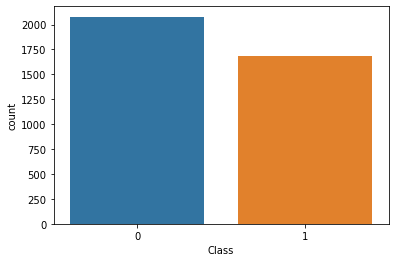

In [6]:
# Plot the value count
sns.countplot(brain_df['Class'])

In [7]:
# Get image paths to build a dictionary for data generators
path_list = []
base_path = '../input/brain-tumor/Brain Tumor/Brain Tumor'
for entry in os.listdir(base_path):
    path_list.append(os.path.join(base_path, entry))

In [8]:
# Create path dictionary and map it to brain_df['paths']
paths_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
brain_df['Path'] = brain_df['Image'].map(paths_dict.get)
brain_df.head()

,Image,Class,Path
0,Image1,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...
1,Image2,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...
2,Image3,1,../input/brain-tumor/Brain Tumor/Brain Tumor/I...
3,Image4,1,../input/brain-tumor/Brain Tumor/Brain Tumor/I...
4,Image5,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...


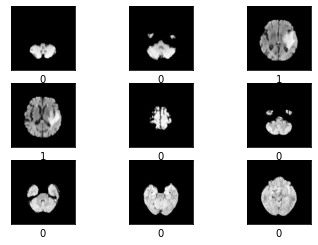

In [9]:
# Plot few samples
for x in range(0,9):
    plt.subplot(3,3,x+1)
    # Remove x and y axis scales
    plt.xticks([])
    plt.yticks([])
    img = imread(brain_df['Path'][x])
    plt.imshow(img)
    plt.xlabel(brain_df['Class'][x])

In [10]:
# Split brain_df into test and train lists for data generators
brain_df['split'] = np.random.randn(brain_df.shape[0], 1)

msk = np.random.rand(len(brain_df)) <= 0.8

train_df = brain_df[msk]
test_df = brain_df[~msk]
train_df.to_csv('brain_tumor_train.csv', index=False)
test_df.to_csv('brain_tumor_test.csv', index=False)
train_list = train_df.values.tolist()
test_list = test_df.values.tolist()

## Data Preprocessing
1. Data Cleaning. Data is clean; images are stored in one folder with feature and label details located in csv file.
2. Data Integration. Data is coming from one source; no data integration techniques were applied.
3. Data Transformation. Images were resized to 224x224 (below, in the generator function) for MobileNetV2 pretrained base, converted to float and numpy array format for CNN. For the future: data augmentation?
4. Data Reduction. No data reduction techniques were used (ignoring image size reduction from 240x240 to 224x224). Furthermore, we cannot decrease the number of channels (could have been a possibility since images are almost black and white) due to the pretrained model that expects 3 channels as the input.
5. Data discretization. Not applicable to images; the inputs are already discrete.

### Data Generator
Below is a generator function taken from [this article](https://medium.com/@anuj_shah/creating-custom-data-generator-for-training-deep-learning-models-part-2-be9ad08f3f0e). Used due to CPU limitations.

In [11]:
from random import shuffle
import cv2
def generator(samples, batch_size=32,shuffle_data=True):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                label = batch_sample[1]
                img_path = batch_sample[2]
                img =  cv2.imread(img_path)
                
                # apply any kind of preprocessing
                # img = cv2.resize(img,(resize,resize))
                img = img.astype(np.float32)
                # Add example to arrays
                X_train.append(keras.applications.nasnet.preprocess_input(img))
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

In [12]:
# Create test and train generators
train_generator = generator(train_list)
test_generator = generator(test_list)

## Building Model

In [14]:
model = Sequential([
    # base
    MobileNetV2(input_shape=(224, 224, 3),include_top=False, weights='imagenet'),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid',name='preds'),   
])
model.layers[0].trainable= False
# show model summary
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
preds (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


## Optimization

In [15]:
model.compile(
    # Set the loss as binary_crossentropy
    loss='binary_crossentropy',
    # Set the optimizer to Adam
    optimizer=keras.optimizers.Adam(epsilon=0.01),
    # Set the metric as accuracy
    metrics=['binary_accuracy']
)

## Training Model

In [16]:
# Set parameters for model training
batch_size = 32
train_size = len(train_list)
test_size = len(test_list)
steps_per_epoch = train_size//batch_size
validation_steps = test_size//batch_size

In [17]:
# Use early stopping to cut resource wasting
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [18]:
# Train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=110,
    validation_data=test_generator,
    validation_steps = validation_steps,
    verbose=1,
    callbacks = [early_stopping]
)
model.save("model_brain_adam.h5")
print("Saved model to disk")

Epoch 1/110
94/94 [==============================] - 97s 1s/step - loss: 0.6116 - binary_accuracy: 0.6818 - val_loss: 0.4113 - val_binary_accuracy: 0.8342
Epoch 2/110
94/94 [==============================] - 14s 145ms/step - loss: 0.4094 - binary_accuracy: 0.8265 - val_loss: 0.3342 - val_binary_accuracy: 0.8723
Epoch 3/110
94/94 [==============================] - 12s 127ms/step - loss: 0.3498 - binary_accuracy: 0.8473 - val_loss: 0.2996 - val_binary_accuracy: 0.8832
Epoch 4/110
94/94 [==============================] - 16s 166ms/step - loss: 0.3266 - binary_accuracy: 0.8633 - val_loss: 0.2750 - val_binary_accuracy: 0.8967
Epoch 5/110
94/94 [==============================] - 15s 164ms/step - loss: 0.3066 - binary_accuracy: 0.8730 - val_loss: 0.2602 - val_binary_accuracy: 0.9008
Epoch 6/110
94/94 [==============================] - 15s 161ms/step - loss: 0.2895 - binary_accuracy: 0.8790 - val_loss: 0.2482 - val_binary_accuracy: 0.9090
Epoch 7/110
94/94 [==============================] - 14

## Results

Best Validation Loss: 0.1718
Best Validation Accuracy: 0.9402


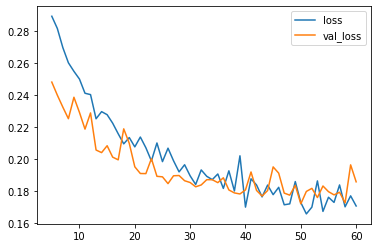

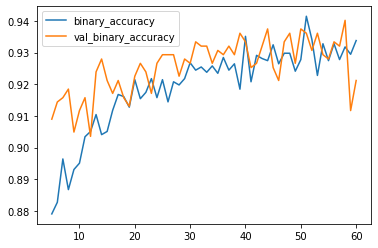

In [19]:
# Graph loss and binary accuracy graphs
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [22]:
# Evaluate samples using the model I've pretrained, saved, and loaded back
pretrained_cnn = keras.models.load_model('./model_brain_adam.h5')
eval_score = pretrained_cnn.evaluate(test_generator, steps = validation_steps)
# print loss score
print('Eval loss:',eval_score[0])
# print accuracy score
print('Eval accuracy:',eval_score[1])

23/23 [==============================] - 2s 67ms/step - loss: 0.1742 - binary_accuracy: 0.9361
Eval loss: 0.17418691515922546
Eval accuracy: 0.936141312122345


In [23]:
# Output classification report and confusion matrix
from sklearn.metrics import confusion_matrix , classification_report
# Get predicted and true classes for our report and matrix
y_pred = np.rint(pretrained_cnn.predict_generator(test_generator, steps = validation_steps)).astype(int)
y_test = [i[1] for i in test_list[0:-2]]
target_classes = ['No Tumor','Tumor']

classification_report(y_test , y_pred , output_dict = True
                      , target_names=target_classes)

{'No Tumor': {'precision': 0.9421686746987952,
  'recall': 0.9444444444444444,
  'f1-score': 0.9433051869722556,
  'support': 414},
 'Tumor': {'precision': 0.9283489096573209,
  'recall': 0.9254658385093167,
  'f1-score': 0.926905132192846,
  'support': 322},
 'accuracy': 0.936141304347826,
 'macro avg': {'precision': 0.935258792178058,
  'recall': 0.9349551414768806,
  'f1-score': 0.9351051595825508,
  'support': 736},
 'weighted avg': {'precision': 0.9361225274931502,
  'recall': 0.936141304347826,
  'f1-score': 0.936130163006264,
  'support': 736}}

In [24]:
confusion_matrix(y_test , y_pred ) 

array([[391,  23],
       [ 24, 298]])

## Conclusion
We misclassified 43 images out of 693, with sensitivity of 94.006% and specificity of 94.272%.